In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import random

train_dir = os.getcwd() + "/../train/"
train_files = os.listdir(train_dir)

bad_imgs_path = os.path.join(os.getcwd(), "badimgs.txt")
with open(bad_imgs_path, "r") as f:
    bad_imgs = {line.strip() for line in f if line.strip()}

# UTILS

def get_rand_img_path():
    return train_dir + random.choice(train_files)

def get_img(label):
    path = os.path.join(train_dir,f"{label}-0.png")
    img = cv2.imread(path)
    return img

def get_label(img_path):
    filename = os.path.basename(img_path)
    label = filename.split('-')[0]
    return label

def get_rand_img():
    path = get_rand_img_path()
    label = get_label(path)
    img = cv2.imread(path)
    return img, label

def show_img(img, title=None):
    plt.figure()
    plt.axis("off")
    if title is not None:
        plt.title(title)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

def remove_lines(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV)
    
    # Remove lines
    removed = cv2.inpaint(img, mask, 3, cv2.INPAINT_NS)
    
    return removed

In [2]:
def high_pass_edges(img, method='laplacian', ksize=3):
    """
    Apply a high-pass filter to detect edges in an image.

    :param img: Input image (BGR or grayscale)
    :param method: 'laplacian' or 'sobel'
    :param ksize: Kernel size for filtering (must be odd)
    :return: Edge-detected image (grayscale)
    """
    # Convert to grayscale if needed
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img.copy()

    if method == 'laplacian':
        edges = cv2.Laplacian(gray, cv2.CV_64F, ksize=ksize)
    elif method == 'sobel':
        # Sobel in x and y directions
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)
        edges = np.sqrt(sobelx**2 + sobely**2)
    else:
        raise ValueError("Method must be 'laplacian' or 'sobel'")

    # Convert back to 8-bit
    edges = cv2.convertScaleAbs(edges)

    return edges

In [3]:
def is_merged_character(contour, avg_width=None, width_threshold=1.5):
    """
    Detect if a contour likely contains multiple merged characters.
    
    :param contour: Contour to check
    :param avg_width: Average width of single characters (if known)
    :param width_threshold: Multiplier to determine if width is too large
    :return: Boolean indicating if character is likely merged
    """
    x, y, w, h = cv2.boundingRect(contour)
    
    # If we don't have average width, use aspect ratio heuristic
    if avg_width is None:
        aspect_ratio = w / h
        # Typical single character has aspect ratio < 1.2, merged chars are wider
        return aspect_ratio > width_threshold
    else:
        # Compare to average width
        return w > (avg_width * width_threshold)

def split_merged_characters(img_clean, edge_img, contour, target_size=(64, 64), num_chars=2, padding=5):
    """
    Split a merged character contour into separate characters.
    
    :param img_clean: Cleaned captcha image
    :param edge_img: Edge-detected image
    :param contour: Merged contour to split
    :param target_size: Output size for each character
    :param num_chars: Estimated number of merged characters
    :param padding: Padding around each character
    :return: List of split character images
    """
    x, y, w, h = cv2.boundingRect(contour)
    
    # Extract the merged region
    x_pad = max(0, x - padding)
    y_pad = max(0, y - padding)
    w_pad = min(img_clean.shape[1] - x_pad, w + 2*padding)
    h_pad = min(img_clean.shape[0] - y_pad, h + 2*padding)
    
    roi = img_clean[y_pad:y_pad+h_pad, x_pad:x_pad+w_pad]
    edge_roi = edge_img[y_pad:y_pad+h_pad, x_pad:x_pad+w_pad]
    
    # Convert to grayscale if needed
    if len(roi.shape) == 3:
        roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    else:
        roi_gray = roi.copy()
    
    # Method 1: Vertical projection to find split points
    # Sum pixel intensities along each column
    vertical_projection = np.sum(edge_roi, axis=0)
    
    # Smooth the projection to reduce noise
    from scipy.ndimage import gaussian_filter1d
    smoothed = gaussian_filter1d(vertical_projection, sigma=2)
    
    # Find local minima (valleys) as potential split points
    # These are columns with least edge activity
    from scipy.signal import find_peaks
    inverted = -smoothed
    peaks, _ = find_peaks(inverted, distance=w//num_chars//2)
    
    # If we found good split points, use them
    if len(peaks) >= num_chars - 1:
        split_points = sorted(peaks[:num_chars-1])
    else:
        # Fallback: split evenly
        split_points = [int(w_pad * i / num_chars) for i in range(1, num_chars)]
    
    # Extract individual characters
    characters = []
    prev_x = 0
    
    for split_x in split_points + [w_pad]:
        char_roi = roi_gray[:, prev_x:split_x]
        
        # Resize and normalize
        char_normalized = resize_and_normalize(char_roi, target_size)
        characters.append(char_normalized)
        
        prev_x = split_x
    
    return characters

def resize_and_normalize(img, target_size=(64, 64)):
    """
    Resize image to target size while maintaining aspect ratio and centering.
    
    :param img: Input image (grayscale)
    :param target_size: Target (width, height)
    :return: Normalized image
    """
    h, w = img.shape
    aspect_ratio = w / h
    
    if aspect_ratio > 1:  # Width > Height
        new_w = target_size[0]
        new_h = int(new_w / aspect_ratio)
    else:  # Height >= Width
        new_h = target_size[1]
        new_w = int(new_h * aspect_ratio)
    
    # Ensure dimensions are at least 1
    new_w = max(1, new_w)
    new_h = max(1, new_h)
    
    # Resize
    resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
    
    # Create canvas and center
    canvas = np.zeros(target_size, dtype=np.uint8)
    y_offset = (target_size[1] - new_h) // 2
    x_offset = (target_size[0] - new_w) // 2
    canvas[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized
    
    return canvas

def extract_character_from_outline(img_clean, edge_img, contour, target_size=(64, 64), padding=5):
    """
    Extract a character from the original image using edge contour information.
    
    :param img_clean: Original cleaned image (color or grayscale)
    :param edge_img: Edge-detected image used to find contours
    :param contour: Single contour from cv2.findContours
    :param target_size: Output size (width, height) for normalization
    :param padding: Extra pixels to add around the bounding box
    :return: Normalized character image
    """
    # Get bounding box with padding
    x, y, w, h = cv2.boundingRect(contour)
    
    # Add padding but ensure we don't go out of bounds
    x_pad = max(0, x - padding)
    y_pad = max(0, y - padding)
    w_pad = min(img_clean.shape[1] - x_pad, w + 2*padding)
    h_pad = min(img_clean.shape[0] - y_pad, h + 2*padding)
    
    # Extract ROI from the cleaned image
    roi = img_clean[y_pad:y_pad+h_pad, x_pad:x_pad+w_pad]
    
    # Create a mask for this specific contour
    mask = np.zeros((h_pad, w_pad), dtype=np.uint8)
    
    # Adjust contour coordinates relative to the ROI
    contour_adjusted = contour.copy()
    contour_adjusted[:, :, 0] -= x_pad
    contour_adjusted[:, :, 1] -= y_pad
    
    # Fill the contour on the mask
    cv2.drawContours(mask, [contour_adjusted], -1, 255, -1)
    
    # Apply mask to ROI
    if len(roi.shape) == 3:
        roi_masked = cv2.bitwise_and(roi, roi, mask=mask)
        # Convert to grayscale for consistency
        roi_masked = cv2.cvtColor(roi_masked, cv2.COLOR_BGR2GRAY)
    else:
        roi_masked = cv2.bitwise_and(roi, roi, mask=mask)
    
    # Resize to target size while maintaining aspect ratio
    h_roi, w_roi = roi_masked.shape
    aspect_ratio = w_roi / h_roi
    
    if aspect_ratio > 1:  # Width > Height
        new_w = target_size[0]
        new_h = int(new_w / aspect_ratio)
    else:  # Height >= Width
        new_h = target_size[1]
        new_w = int(new_h * aspect_ratio)
    
    # Resize
    resized = cv2.resize(roi_masked, (new_w, new_h), interpolation=cv2.INTER_AREA)
    
    # Create canvas and center the character
    canvas = np.zeros(target_size, dtype=np.uint8)
    y_offset = (target_size[1] - new_h) // 2
    x_offset = (target_size[0] - new_w) // 2
    canvas[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized
    
    return canvas

def extract_all_characters(img_clean, edge_img, min_area=200, max_area=10000, target_size=(64, 64), padding=5, split_threshold=1.5):
    """
    Extract all character regions, splitting merged characters.
    
    :param img_clean: Cleaned captcha image
    :param edge_img: Edge-detected image
    :param min_area: Minimum contour area
    :param max_area: Maximum contour area
    :param target_size: Output size for each character
    :param padding: Padding around characters
    :param split_threshold: Width multiplier to detect merged characters
    :return: List of normalized character images and their positions
    """
    # Threshold and morphology
    _, mask = cv2.threshold(edge_img, 30, 255, cv2.THRESH_BINARY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, kernel, iterations=1)
    
    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Filter and get valid contours
    valid_contours = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if min_area <= area <= max_area:
            valid_contours.append(cnt)
    
    # Calculate average width for single characters
    if len(valid_contours) > 0:
        widths = [cv2.boundingRect(cnt)[2] for cnt in valid_contours]
        avg_width = np.median(widths)
    else:
        avg_width = None
    
    characters = []
    positions = []
    
    for cnt in valid_contours:
        x, y, w, h = cv2.boundingRect(cnt)
        
        # Check if this is a merged character
        if is_merged_character(cnt, avg_width, split_threshold):
            # Estimate number of merged characters
            if avg_width:
                num_chars = max(2, int(round(w / avg_width)))
            else:
                num_chars = 2
            
            # Split the merged characters
            split_chars = split_merged_characters(img_clean, edge_img, cnt, target_size, num_chars, padding)
            
            # Add split characters with estimated positions
            for i, char_img in enumerate(split_chars):
                characters.append(char_img)
                # Estimate x position for each split character
                split_x = x + (w * i // num_chars) + (w // num_chars // 2)
                positions.append((split_x, x + (w * i // num_chars), y, w // num_chars, h))
        else:
            # Normal single character extraction
            char_img = extract_character_from_outline(img_clean, edge_img, cnt, target_size, padding)
            center_x = x + w // 2
            characters.append(char_img)
            positions.append((center_x, x, y, w, h))
    
    # Sort by x-position (left to right)
    sorted_data = sorted(zip(characters, positions), key=lambda x: x[1][0])
    characters = [char for char, _ in sorted_data]
    positions = [pos for _, pos in sorted_data]
    
    return characters, positions

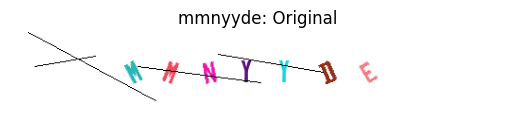

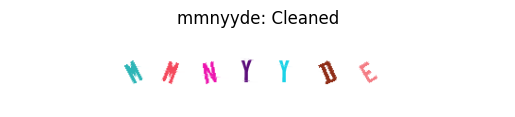

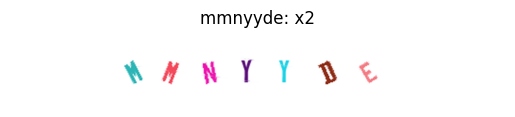

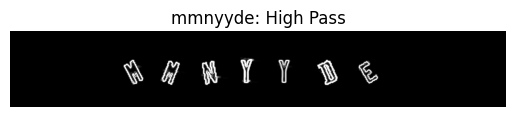

Found 7 characters


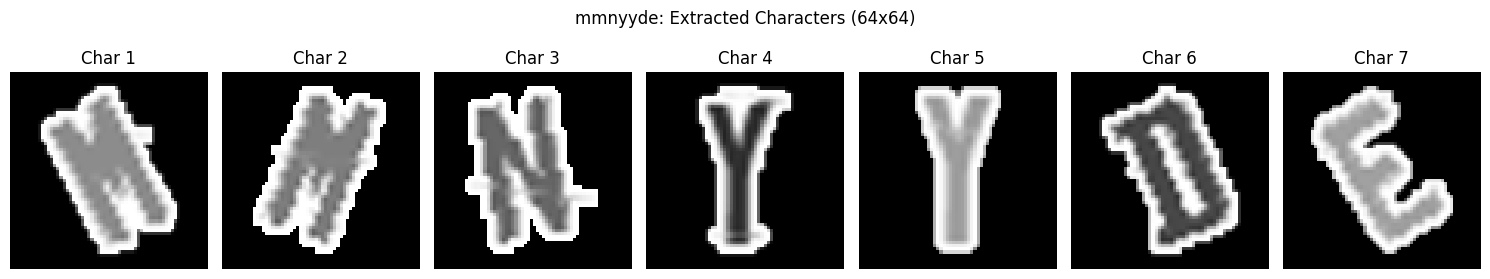

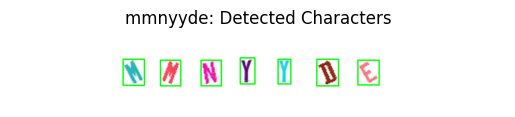

In [4]:
img, label = get_rand_img()
show_img(img, title=f"{label}: Original")

img_clean = remove_lines(img)
show_img(img_clean, title=f"{label}: Cleaned")

SCALE = 2.0
img_clean = cv2.resize(img_clean, None, fx=SCALE, fy=SCALE, interpolation=cv2.INTER_CUBIC)
show_img(img_clean, title=f"{label}: x2")

edges = high_pass_edges(img_clean, method='sobel')
show_img(edges, f"{label}: High Pass")

# Extract characters
characters, positions = extract_all_characters(img_clean, edges, min_area=200, max_area=10000, target_size=(64, 64))

print(f"Found {len(characters)} characters")

# Display extracted characters
fig, axes = plt.subplots(1, len(characters), figsize=(15, 3))
if len(characters) == 1:
    axes = [axes]

for idx, char in enumerate(characters):
    axes[idx].imshow(char, cmap='gray')
    axes[idx].axis('off')
    axes[idx].set_title(f'Char {idx+1}')

plt.suptitle(f"{label}: Extracted Characters (64x64)")
plt.tight_layout()
plt.show()

# Optional: Show with bounding boxes on original
img_with_boxes = img_clean.copy()
for _, (_, x, y, w, h) in zip(characters, positions):
    cv2.rectangle(img_with_boxes, (x, y), (x+w, y+h), (0, 255, 0), 2)

show_img(img_with_boxes, f"{label}: Detected Characters")

In [7]:
def high_pass_pipeline(img):
    img_clean = remove_lines(img)
    SCALE = 2.0
    img_clean = cv2.resize(img_clean, None, fx=SCALE, fy=SCALE, interpolation=cv2.INTER_CUBIC)
    edges = high_pass_edges(img_clean, method='sobel')

    characters, positions = extract_all_characters(img_clean, edges, min_area=200, max_area=10000, target_size=(64, 64), split_threshold=1.4)
    return characters

In [8]:
results = [0, 0]

for f in train_files:
    if f not in bad_imgs:
        img = cv2.imread(train_dir + f)
        chars = high_pass_pipeline(img)
        if len(chars) == len(f[:-6]):
            results[0] += 1
        else:
            results[1] += 1

print(results, results[0]/sum(results))

[6104, 1796] 0.7726582278481012
